# Testar Distribuição Uniforme de Numeros Aleatorios Gerados em Paralelo

A principal dificuldade que eu tive ao realizar este trabalho foi que eu busquei otimizar o tempo de execução das simulações,
explorando tecnicas de paralelismo à partir de recursos ociosos de processamento dos computadores onde ela foi executada, pois,
a primeira versão das simulações não estava paralelizada e por isso, executava mais lenta (4x) do que uma potencial versão paralelizada.

Assim fui em busca de paralelizar este código. Consegui paralelizar a execução, mas, me deparei com um outro desafio: o de garantir a sincronia entre os geradores de números pseudo aleatórios utilizados para simular o fenômeno de deposição de partículas, pois, se tal sincronia não for garantida, pode haver sobreposição de gerações de amostras (repetições de valores - overlaps) o que de fato ocorreu.

Assim, busquei alternativas para contornar este problema e estudando o algoritmo de geração cngruencial de números pseudo aleatórios proposto pelo trabalho, o URAND, verifiquei que ele por se tratar de uma recorrência e utilizando os recursos da linguagem python que teoricamente permitem o armazenamento de números inteiros extremamente grandes, até o limite de memória disponível no computador, resolvi a recorrência que o representa e encontrei uma equação que poderia ser utilizada para prever qual número seria gerado a partir de $t$ instantes de tempos.

A recorrência do gerador URAND é:

$$
    R(t) = A * R(t - 1) + B
$$

Onde $A = 843314861$ e $B = 453816693$

Essa recorrência em sua forma fechada é dada por:

$$
R(t) = R(0) {A}^{t} + \frac{{B}({A}^{t} - 1)}{A - 1}
$$

E ela apresenta de fato o valor de R gerado em qualquer instante de tempo $t$, mas, com um custo exponencial, como apontado nesta forma fechada. Então, é mais dispendioso prever o valor gerado no tempo $t$ (custo exponencial) do que executar o gerador de números aleatórios $t$ instantes para descobrir o valor buscado.

Infelizmente não me atinei para este fato inicialmente, então em muitas simulações executei esta forma fechada ineficiente para prever os valores do gerador de numero aleatorios em um instante de tempo $t$ e garantir sincronia entre amostras, mas, como deduzido, é mais custoso computecionalmente prever estes números do que executar o gerador $t$ vezes. Assim, na forma que eu desenvolvi, a paralelização não traria benefícios, pelo contrário, induziria custos exponenciais na simulação para prever os valores a serem gerados.

Por isso, desesti inicialmente de fazer a abordagem paralela, mas, ao estudar a documentação da biblioteca numpy na manhã de sábado 05/12/2020, verifiquei que a biblioteca possui suporte nativo para geração uniformemente distribuída de números aleatórios em paralelo, à partir de um gerador congruencial **PCG64** e que também permite avançar o gerador em $t$ passos de execução em custo $ O(1) $ o que atende os requisitos de sincronia para evitar a sobreposição (repetição de valores gerados) da simulação.

Além do que o gerador **PCG64** apresenta custo logarítimico para gerar n números aleatórios, em comparação ao custo linear do gerador URAND convencional.

Assim este teste visa:

1. Comprovar a eficiência de custo computacional do gerador **PCG64** em comparação ao URAND
2. Verificar a uniformidade da distribuição gerada pelo **PCG64**, também pelo **URAND** e comparar a uniformidade das duas distribuições, para atestar que o **PCG64** pode ser utilizado para simular as deposições
3. Verificar que não ocorre sobreposição de valores gerados quando n geradores são avançados em $ t $ múltiplos instantes de tempo, para gerarem numeros aleatórios em paralelo.

## 1. Teste de eficiência do custo computacional do gerador PCG64 em comparação ao URAND

In [11]:
from rng import RNG_PCG, RNG_URAND
import numpy as np

rng_urand = RNG_URAND(0)
rng_pcg = RNG_PCG(0)

n = 10**6
tempo_urand = %timeit -o gerados_urand = [rng_urand.rng() for i in range(n)];
tempo_pcg = %timeit -o gerados_pcg = rng_pcg.rng(numbers = n);
print('Tempo de Execução Gerador URAND - Geração de {} números: {:6f}s'.format(n, tempo_urand.average))
print('Tempo de Execução Gerador PCG64 - Geração de {} números: {:6f}s'.format(n, tempo_pcg.average))
print('O gerador PCG64 é ~ {} vezes mais rápido que o URAND para gerar {} números'.format(np.round(tempo_urand.average / tempo_pcg.average), n))

4.09 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.94 ms ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tempo de Execução Gerador URAND - Geração de 1000000 números: 4.088458s
Tempo de Execução Gerador PCG64 - Geração de 1000000 números: 0.003939s
O gerador PCG64 é ~ 1038.0 vezes mais rápido que o URAND para gerar 1000000 números


## 2.1 Verificação de uniformidade do gerador congruencial PCG64

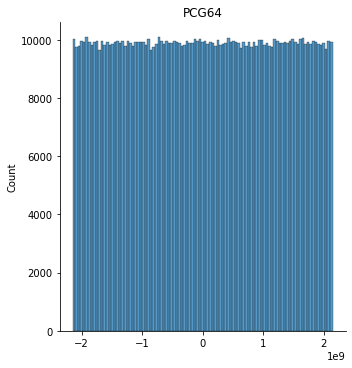

In [9]:
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns

gerados_pcg = rng_pcg.rng(high = 2**31, low = -2**31, numbers = n)
sns.displot(gerados_pcg)
pyplot.title('PCG64');


## 2.2 Verificação de uniformidade do gerador congruencial URAND

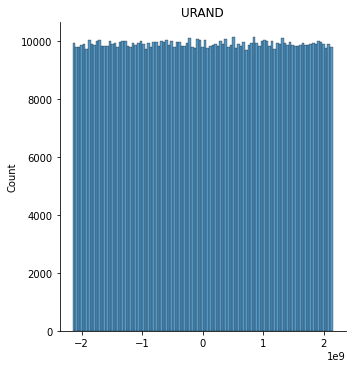

In [10]:
%matplotlib inline

gerados_urand = [rng_urand.rng() for i in range(n)]
sns.displot(gerados_urand)
pyplot.title('URAND');

Comparando as distribuições de 1 milhão de números inteiros de 32 bits geradas pelo URAND e pelo PCG64, identificamos que PCG64 é tão uniforme quanto URAND, o que torna o gerador congruencial PCG64 apto para a simulação dos fenômenos de deposição

## 3. Verificação da não ocorrência de sobreposição para valores gerados em paralelo

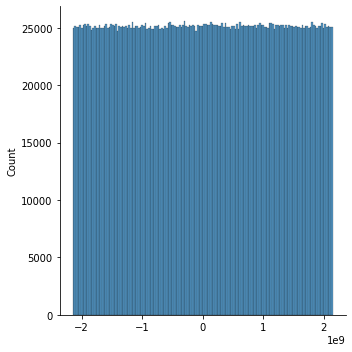

In [15]:
%matplotlib inline

import seaborn as sns
from multiprocessing import Pool
from numpy.random import default_rng, PCG64

n = 10**6
cores = 4

def rng_paralelo(rng):
    return rng.integers(-2**31, 2**31, n)

# instancio os geradores base
geradores = [PCG64(0) for c in range(cores)]
# avanco o estado dos geradores em c * n de numeros gerados
for c in range(cores):
    geradores[c].advance(c * n)
rngs = [default_rng(g) for g in geradores]

# simulo em paralelo
pool = Pool()
numeros_gerados = pool.map(rng_paralelo, rngs)
pool.close()

# ploto a distribuição dos numeros gerados
# ocorrerá overlap se existir desbalanceamento entre
# os numeros sorteados, se alguns forem muito mais
# sorteados do que outros.
# Caso todos apresentem alturas médias parecidas
# A geração de numeros aleatorios foi bem sucedidade
# e manteve o requisito da uniformidade respeitado,
# necessário para simular adequadamente o fenômeno
# da deposição de partículas
sns.displot(np.concatenate(numeros_gerados))

Como verificado, não ocorreu overlap, o que permite que utilizemos o gerador PCG64, adequadamente uniforme e muito eficiente para simular as deposições!